In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import pickle
import matplotlib.pyplot as plt

In [2]:
# the dataset path
file_dir = './../data/flight_price_pred.csv'

In [3]:
# reading the dataset
df = pd.read_csv(file_dir)

### Redefine the dataset

In [4]:
# grab relevant features
df = df[['airline','class','source_city','departure_time','stops','arrival_time','destination_city','duration','days_left','price']]
df.rename(columns = {'class':'classes'}, inplace = True)

In [5]:
# to convert the price column to malaysia ringgit
conversion_rate = 17.58 # indian rupee to malaysia ringgit as of 30 Jan 2024 (source: google)
df['price'] = (df['price'] / conversion_rate).round(2)

### Data Preprocessing

In [6]:
# split between target feature & non-target features
y = df['price'] # target
pre_x = df.drop('price', axis=1) # non-target

In [7]:
# transform all of the categorical data into one-hot encoding
dm_X = pd.get_dummies(pre_x)

In [8]:
# normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(dm_X)

### Data Modeling (Logistic Regression)

In [9]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# initialize model & train it
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [11]:
# predict test dataset
y_pred = lr_model.predict(X_test)

# model evaluation
lr_model_mse = mean_squared_error(y_test, y_pred)
lr_model_r2 = r2_score(y_test, y_pred)

# the model performance result
print(f'Mean Squared Error: {lr_model_mse}')
print(f'R-squared: {lr_model_r2}')

Mean Squared Error: 147937.6381124117
R-squared: 0.9113042606671888


### Data Modeling (Deep Learning)

In [12]:
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

opt = tf.keras.optimizers.Adam(0.01)
tf_model.compile(optimizer=opt, loss='mse')

In [13]:
tf_result = tf_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 209345.6719 - val_loss: 109213.1094
Epoch 2/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 69558.6016 - val_loss: 64448.9609
Epoch 3/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 63345.5078 - val_loss: 59540.2969
Epoch 4/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 61085.0742 - val_loss: 67062.4688
Epoch 5/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 59876.0781 - val_loss: 59881.6562
Epoch 6/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 57848.3633 - val_loss: 56648.2812
Epoch 7/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 56586.7969 - val_loss: 54620.1133
Epoch 8/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 55910.3203 - val_loss: 56107.7656
Epoch 9/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 54314.7344 - val_loss: 54273.7852
Epoch 10/100
6004/6004 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 54434.2148 - val_loss: 59575.9258
Epoch 11/100
6004

In [14]:
loss = tf_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

1876/1876 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 46162.7773
Test Loss: 46149.47265625


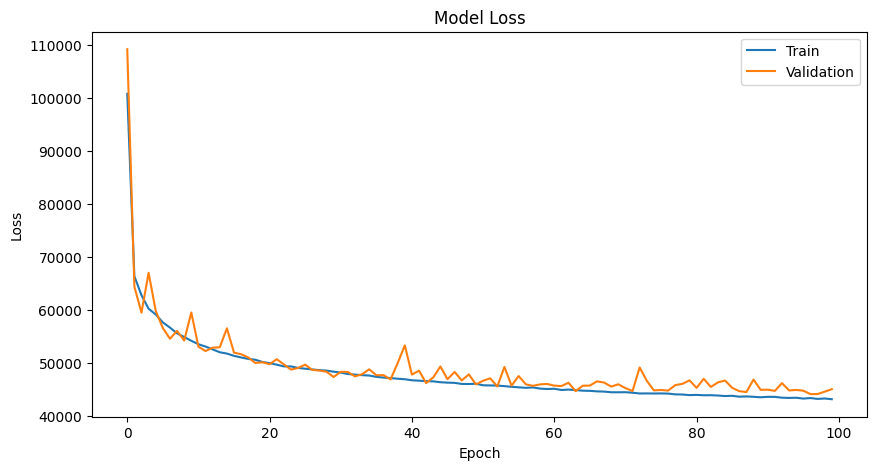

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(tf_result.history['loss'])
plt.plot(tf_result.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Saving the models

In [16]:
# save the models
pickle.dump(lr_model, open("./../models/lr_model.pkl", "wb"))            # saving the linear regression model
pickle.dump(dm_X.columns, open("./../models/all_cats_ohe.pkl", "wb"))    # saving the cats columns of this dataset
pickle.dump(scaler, open("./../models/scaler.pkl", "wb"))                # saving the normalize tools
tf_model.save('./../models/ann_model.keras')